## [Students] Shopee Code League - Order Brushing

Hendrik Lesmana

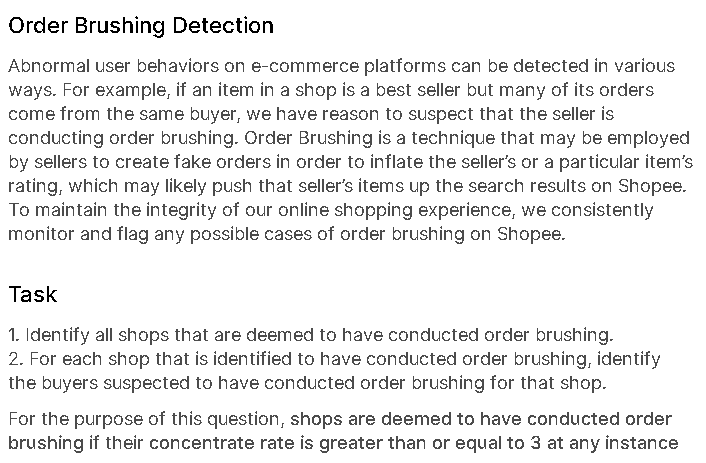

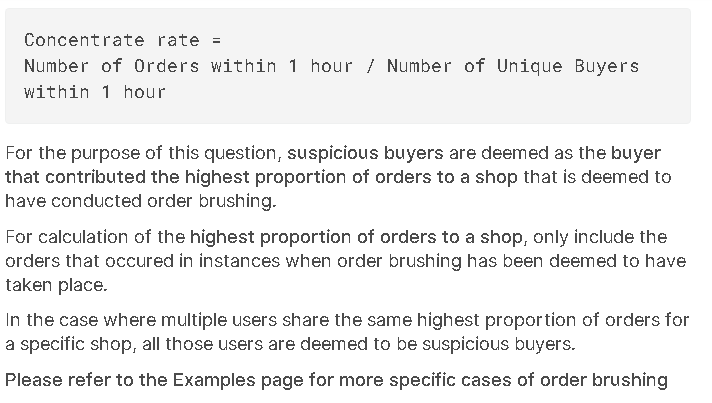

Basic Concepts
- Each orderid represents a distinct transaction on Shopee.
- Each unique shopid is a distinct seller on Shopee.
- Each unique userid is a distinct buyer on Shopee.

Event Time refers to the exact time that an order was placed on Shopee.

Concentrate rate is a possible measure that we use to determine whether a shop is likely to have conducted order brushing. For this question, the threshold for concentrate rate is 3. Any concentrate rate value equal to or greater than 3 is deemed to be an occurence of order brushing.

Approach:
1. Select 1 hour window and take a slice from order Data(set the time condition, included in the 1 hour window)
2. Find shops which reports based on Mean+(3*STD), more than that They are brushing shops.
3. Find the userid who conducts order brushing(use aggregation function '&' to separate the differences)
4. Do inner join to the original dataset

In [145]:
import pandas as pd
import numpy as np

In [146]:
data = pd.read_csv('order_brush_order.csv')

In [147]:
data.head()

,orderid,shopid,userid,event_time
0,31076582227611,93950878,30530270,2019-12-27 00:23:03
1,31118059853484,156423439,46057927,2019-12-27 11:54:20
2,31123355095755,173699291,67341739,2019-12-27 13:22:35
3,31122059872723,63674025,149380322,2019-12-27 13:01:00
4,31117075665123,127249066,149493217,2019-12-27 11:37:55


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222750 entries, 0 to 222749
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   orderid     222750 non-null  int64 
 1   shopid      222750 non-null  int64 
 2   userid      222750 non-null  int64 
 3   event_time  222750 non-null  object
dtypes: int64(3), object(1)
memory usage: 5.9+ MB


event_time shows in object type. It should be datetime type, because the concentrate rate of orders are within 1 hour

In [149]:
data['event_time'] = pd.to_datetime(data['event_time'])

In [150]:
data.nunique()

orderid       222750
shopid         18770
userid         93883
event_time    121064
dtype: int64

There are  18770 unique shopid, this is going to be the key answer and show which one conduct order brushing and which one is not

In [151]:
data_time = data.set_index(data['event_time']).sort_index()
data_time.head()

,orderid,shopid,userid,event_time
event_time,,,,
2019-12-27 00:00:00,31075200506751,6042309,97707522,2019-12-27 00:00:00
2019-12-27 00:00:00,31075200506752,104804492,97707522,2019-12-27 00:00:00
2019-12-27 00:00:00,31075200506753,8715449,97707522,2019-12-27 00:00:00
2019-12-27 00:00:02,31075201870570,190969466,170182475,2019-12-27 00:00:02
2019-12-27 00:00:05,31075205798264,2859407,12532131,2019-12-27 00:00:05


Why do we need set_index()?
- set_index() is a method to set a List of Data Frame. Indexes are used to quickly locate data without having to search every row in a table, everytime the table accessed

In [152]:
data_time = data_time.drop('event_time', axis=1)
data_time.head()

,orderid,shopid,userid
event_time,,,
2019-12-27 00:00:00,31075200506751,6042309,97707522
2019-12-27 00:00:00,31075200506752,104804492,97707522
2019-12-27 00:00:00,31075200506753,8715449,97707522
2019-12-27 00:00:02,31075201870570,190969466,170182475
2019-12-27 00:00:05,31075205798264,2859407,12532131


Index gives a unique identifier for every row

In [153]:
group_order = data_time.groupby(['shopid', 'userid', pd.Grouper(freq='60min')]).count()
group_order.head()

orderid
shopid userid    event_time                  
10009  196962305 2019-12-27 03:00:00        1
10051  2854032   2019-12-27 19:00:00        1
       48600461  2019-12-29 01:00:00        1
10061  62464559  2019-12-31 02:00:00        1
       130633421 2019-12-30 21:00:00        1

A pd.Grouper() is used to group dataframe by a define time interval. In this case, a spesific groupby is to get data within frequency within 60 minutes and count it from every shopid and unique userid within data_time index

- basically, I would like to group every 60 minutes and start grouping at 03:00:00

In [154]:
group_order.rename(columns={'orderid':'n_order'}, inplace=True)
group_order.head()

n_order
shopid userid    event_time                  
10009  196962305 2019-12-27 03:00:00        1
10051  2854032   2019-12-27 19:00:00        1
       48600461  2019-12-29 01:00:00        1
10061  62464559  2019-12-31 02:00:00        1
       130633421 2019-12-30 21:00:00        1

Rename orderid into n_order(number of order) to make it easy to read

In [155]:
import statistics

print("Median of n_order is % s"
     %(group_order['n_order'].median()))
print("Mean of n_order is % s"
     %(group_order['n_order'].mean()))
print("Standard Deviation of n_order is % s"
     %(statistics.stdev(group_order['n_order'])))
print("Mean + (3*Standard Deviation) of n_order is % s"
     %((statistics.stdev(group_order['n_order'])*3) + group_order['n_order'].mean()))

Median of n_order is 1.0
Mean of n_order is 1.0318375741741825
Standard Deviation of n_order is 0.21215125373725185
Mean + (3*Standard Deviation) of n_order is 1.668291335385938


Do a simple analyst using statistics:

Median is a measure to avoid outliers data, median of n_order is 1
Mean of n_order is 1.03
Standard Deviation of n_order is 0.21
I can say that, besides of the outliers. most of the n_order is in range 1.

Mean + (3*Standard Deviation) formula is used to exclude the normal orders(there's no way, each customer only order 1 item. So, to make sure not to make an error asumption, i used the formula to extend the range of the normal order)
The result is 1.67, rounded to be 2.00

Meaning that n_order more than 2 can be a "suspect" of the order brushing.

In [156]:
possible_brushing = group_order[group_order['n_order'] > 2]
possible_brushing.head()

n_order
shopid userid    event_time                  
10159  214988798 2019-12-29 20:00:00        3
10287  198097381 2019-12-30 00:00:00        3
       214226569 2019-12-31 01:00:00        3
10402  77819     2019-12-28 14:00:00        3
10536  672345    2019-12-27 11:00:00        3

In [157]:
userids = []
possible_brushing = possible_brushing.reset_index()
possible_brushing = possible_brushing.groupby('shopid')['userid'].apply(lambda x: userids.append(x.values))
len(userids)

296

- If there are more than 1 possible_brushing(userid). I will use & as separator between one userid and another userid
- lambda function is used to define simple task, to add x.values in after userid placed

In [158]:
def add_and(ands):
    add = '&'.join(str(x) for x in ands)
    return add

concat_to_userids = []
for i in userids:
    concat_to_userids.append(add_and(i))

order_brush_suspect = pd.DataFrame({"shopid": possible_brushing.reset_index()['shopid'].unique(), "userid": concat_to_userids})
order_brush_suspect.head()

,shopid,userid
0,10159,214988798
1,10287,198097381&214226569
2,10402,77819
3,10536,672345&672345
4,29583,214495220&215275495


- By defining a function called add_and, I used an empty variable as representative data and join '&' as separator
- concat_to_userids is a second temporary storage
- implement the function(add_and) to all data by using loop(for) to the userids(the first temporary storage) which has data grouped with possible order brushing data(userid) with a function(lambda) to add x values. The x values is added in the add_and function as '&' to fill into str(x) and then loop(apply to all data)

Lastly, make a dataframe only show shopid and userid which are suspected to do brushing

In [159]:
order_brush_suspect.nunique()

shopid    296
userid    261
dtype: int64

In [160]:
original_data = pd.DataFrame({'shopid':data['shopid'].unique(), 'userid':0})
original_data

,shopid,userid
0,93950878,0
1,156423439,0
2,173699291,0
3,63674025,0
4,127249066,0
...,...,...
18765,163337224,0
18766,772599,0
18767,50236030,0
18768,203587596,0


Get all unique data(shopid) from the original data and set all userid as 0 to represent non-brushing

In [161]:
left_join = pd.concat([original_data[~original_data.shopid.isin(order_brush_suspect.shopid)], order_brush_suspect])

Left join is a function from SQL which returns all rows from the left table.

In [162]:
left_join

,shopid,userid
0,93950878,0
1,156423439,0
2,173699291,0
3,63674025,0
4,127249066,0
...,...,...
291,203531250,114282846
292,204225676,198662175
293,208696908,214111334
294,210197928,52867898


- 295 in the table(represent row numebrs) meaning that there are 295 suspects of shopid to do order brushing
- And  18770-295 = 17475 shopid are clear from order brushing suspect